In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import json
import re
import os

In [2]:
path = "../data/txts/JES"

In [3]:
for dirpath, dirnames, filenames in os.walk(path):
    fnames = [f for f in filenames if f.endswith(".txt")]
print(f"Number of files: {len(fnames)}")

Number of files: 2157


## Average article length in pages:

Mean: 8.7185906351414 | Std: 3.483332358352273 | Max: 27 | Min: 2


(array([169., 431., 800., 346., 280.,  65.,  46.,  13.,   3.,   4.]),
 array([ 2. ,  4.5,  7. ,  9.5, 12. , 14.5, 17. , 19.5, 22. , 24.5, 27. ]),
 <BarContainer object of 10 artists>)

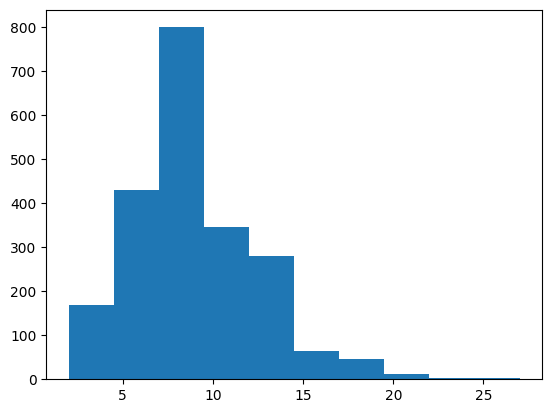

In [4]:
pdf_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
    pdf_lens.append(len(pgs))
print(f"Mean: {np.mean(pdf_lens)} | Std: {np.std(pdf_lens)} | Max: {np.max(pdf_lens)} | Min: {np.min(pdf_lens)}")
plt.hist(pdf_lens)

## Average page length in tokens:

In [5]:
# go one dir up
llama_dir = os.path.join(os.getcwd(), "..", "..", "codellama", "CodeLlama-7b-Instruct-hf")
tokenizer = AutoTokenizer.from_pretrained(llama_dir, local_files_only=True)

Mean: 546.416994576199 | Std: 196.92359012355942 | Max: 2150 | Min: 22


(array([2.290e+03, 7.290e+02, 1.125e+04, 4.289e+03, 1.990e+02, 3.900e+01,
        6.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  22. ,  234.8,  447.6,  660.4,  873.2, 1086. , 1298.8, 1511.6,
        1724.4, 1937.2, 2150. ]),
 <BarContainer object of 10 artists>)

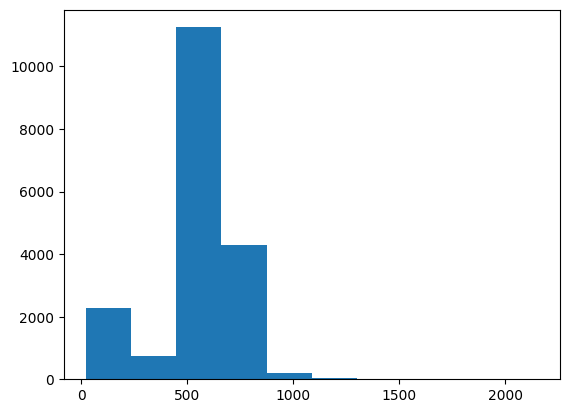

In [6]:
pg_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
        for pg in pgs:
            pg_lens.append(len(tokenizer.tokenize(pg)))
print(f"Mean: {np.mean(pg_lens)} | Std: {np.std(pg_lens)} | Max: {np.max(pg_lens)} | Min: {np.min(pg_lens)}")
plt.hist(pg_lens)

LLaMA2-Code has a functional context length of 16k tokens.

## Prompt Engineering

In [7]:
class jinjitsu():
    def __init__(self, template_dir, template_file, exampleVars):
        self.templateLoader = jinja2.FileSystemLoader(searchpath=template_dir)
        self.templateEnv = jinja2.Environment( loader=self.templateLoader )
        self.template = self.templateEnv.get_template( template_file )
        self.example = self.template.render( exampleVars )

    def render(self, templateVars):
        return self.template.render( templateVars )

In [8]:
with open("../prompts/examples/txt_example.json", "r") as infile:
        exampleVars = json.load(infile)

In [9]:
jinjaLoader = jinjitsu("../prompts", "txt.jinja", exampleVars)

### Average prompt length in tokens:

In [10]:
# runs for a moment
for pgnum in range(1, 7):
    print(f"Prompt length with {pgnum} page(s):")
    prompt_lens = []
    for f in fnames:
        with open(os.path.join(path, f), "r") as infile:
            pgs = infile.read().split("<newpage>")
        templateVars = {"input": "\n".join(pgs[:pgnum]), "output": ""}
        prompt = "\n".join([jinjaLoader.example, jinjaLoader.render( templateVars )])
        prompt_lens.append(len(tokenizer.tokenize(prompt)))
    print(f"Mean: {np.mean(prompt_lens)} | Std: {np.std(prompt_lens)} | Max: {np.max(prompt_lens)} | Min: {np.min(prompt_lens)}")

Prompt length with 1 page(s):
Mean: 1654.6226240148353 | Std: 14.786140686361763 | Max: 1702 | Min: 1614
Prompt length with 2 page(s):
Mean: 2237.5210941121927 | Std: 90.01422720242216 | Max: 2610 | Min: 1805
Prompt length with 3 page(s):
Mean: 2863.578117756143 | Std: 172.52565481779726 | Max: 3501 | Min: 1865
Prompt length with 4 page(s):
Mean: 3469.7320352341217 | Std: 279.1059465512372 | Max: 4446 | Min: 1865
Prompt length with 5 page(s):
Mean: 4040.038942976356 | Std: 417.8468811664212 | Max: 5986 | Min: 1865
Prompt length with 6 page(s):
Mean: 4549.080203987019 | Std: 593.1957403992167 | Max: 6645 | Min: 1865


### Correct JSON response length in tokens:

In [11]:
all_false = json.dumps({"quantitative": False, "qualitative": False, "primary/secondary": False, "tertiary": False, "inequality": False, "nonstructural": False, "culture": False, "school": False, "state": False, "labor": False, "comparative": False, "methods": False})
print(f"Length of max expected JSON output in tokens: {len(tokenizer.tokenize(all_false))}")

Length of max expected JSON output in tokens: 74
